# Qwen2-VL

In this notebook we will use the vision language model [Qwen/Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to inspect an image.

We will use [ScaDS.AI LLM infrastructure](https://llm.scads.ai/) infrastructure at the [Center for Information Services and High Performance Computing (ZIH) of TU Dresden](https://tu-dresden.de/zih). To use it, you must be connected via [TU Dresden VPN](https://tu-dresden.de/zih/dienste/service-katalog/arbeitsumgebung/zugang_datennetz/vpn).

In [1]:
import openai
from skimage.io import imread
import stackview
from image_utilities import numpy_to_bytestream
import base64
from stackview._image_widget import _img_to_rgb
import os
from IPython.display import display, Markdown

## Example image
First we load a microscopy image. With such an example we can test if the model was trained on scientific microscopy data.

StackViewNDArray([[[ 3,  6,  1],
                   [ 3,  7,  0],
                   [ 3,  6,  1],
                   ...,
                   [11,  8,  2],
                   [11,  7,  2],
                   [11, 11,  2]],

                  [[ 3,  6,  1],
                   [ 3,  8,  1],
                   [ 3,  7,  1],
                   ...,
                   [11, 10,  2],
                   [10, 10,  2],
                   [11, 11,  2]],

                  [[ 4,  6,  1],
                   [ 3,  6,  1],
                   [ 4,  6,  1],
                   ...,
                   [10, 10,  2],
                   [11, 10,  2],
                   [11, 10,  2]],

                  ...,

                  [[15, 14,  8],
                   [14, 14,  8],
                   [15, 14,  7],
                   ...,
                   [10, 11,  5],
                   [10, 12,  4],
                   [11, 14,  5]],

                  [[14, 16,  7],
                   [16, 15,  7],
                   [15, 16,  8],
                   ...,
                   [10, 11,  4],
                   [11, 13,  4],
                   [11, 16,  5]],

                  [[15, 18,  7],
                   [14, 17,  8],
                   [14, 17,  8],
                   ...,
                   [ 9, 12,  5],
                   [10, 13,  5],
                   [11, 15,  5]]], dtype=uint8)
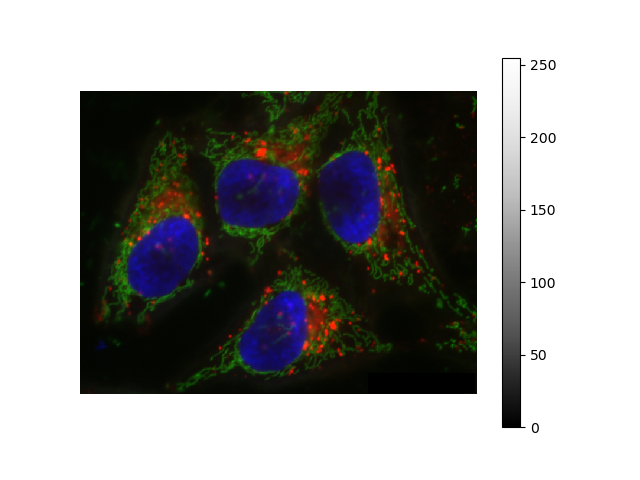
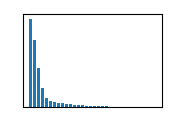

In [2]:
hela_cells = imread("data/hela-cells-8bit.tif")
stackview.insight(hela_cells)

We will now send the image to the LLM server and ask it the some questions.

In [3]:
def prompt_qwen(prompt:str, image, model="Qwen/Qwen2-VL-7B-Instruct"):
    """A prompt helper function that sends a message to the server
    and returns only the text response.
    """
    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    message = [{"role": "user", "content": [
        {"type": "text", "text": prompt},
        {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{base64_image}"
        }
    }]}]
            
    # setup connection to the LLM
    client = openai.OpenAI(base_url="https://llm.scads.ai/v1",
                           api_key=os.environ.get('SCADSAI_API_KEY'))
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    return response.choices[0].message.content

In [4]:
res = prompt_qwen("what's in this image?", hela_cells)

display(Markdown(res))

The image appears to be a microscopic view of biological cells, possibly analyzed using fluorescence microscopy techniques. The cells are stained to highlight different structures:

1. **Blue Areas**: These represent the nuclei of the cells, typically stained with a dye like DAPI or Hoechst that binds to DNA.
2. **Green Structures**: These are likely the plasma membranes of the cells, as visualized by a fluorescence stain like FM1-43, which binds to lipid-bilayer membranes给人。
3. **Red Dots**: These are clusters or puncta that might represent specific signaling molecules or proteins, possibly related to cytokines or receptors participating in cell signaling pathways

## Exercise
Ask the model to specifically describe what is in a selected colour channel. Repeat this exercise with a natural image such as "real_cat.png".